# Домашнее задание к уроку 2: Линейная и логистическая регрессия

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [22]:
# Базовые Dataset классы

class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_regression_data(n=100, noise=0.1, source='random'):
    if source == 'random':
        X = torch.rand(n, 1)
        w, b = 2.0, -1.0
        y = w * X + b + noise * torch.randn(n, 1)
        return X, y
    elif source == 'diabetes':
        from sklearn.datasets import load_diabetes
        data = load_diabetes()
        X = torch.tensor(data['data'], dtype=torch.float32)
        y = torch.tensor(data['target'], dtype=torch.float32).unsqueeze(1)
        return X, y
    else:
        raise ValueError('Unknown source')

def make_classification_data(n=100, source='random'):
    if source == 'random':
        X = torch.rand(n, 2)
        w = torch.tensor([2.0, -3.0])
        b = 0.5
        logits = X @ w + b
        y = (logits > 0).float().unsqueeze(1)
        return X, y
    elif source == 'breast_cancer':
        from sklearn.datasets import load_breast_cancer
        data = load_breast_cancer()
        X = torch.tensor(data['data'], dtype=torch.float32)
        y = torch.tensor(data['target'], dtype=torch.float32).unsqueeze(1)
        return X, y
    else:
        raise ValueError('Unknown source')


# Задание 1: Модификация существующих моделей (30 баллов)

1.1 Расширение линейной регрессии (15 баллов)

In [23]:
# Модифицируйте существующую линейную регрессию:
# - Добавьте L1 и L2 регуляризацию
# - Добавьте early stopping

In [24]:
class LinearRegRegularized(nn.Module):
    """
    Линейная регрессия с поддержкой L1/L2 регуляризации.
    """
    def __init__(self, input_dim):
        super().__init__()
        self.lin = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.lin(x)

def calc_regularization(model, alpha_l1=0.0, alpha_l2=0.0):
    """
    Суммирует регуляризационные штрафы для всех параметров модели.
    """
    l1_sum = sum(p.abs().sum() for p in model.parameters())
    l2_sum = sum((p ** 2).sum() for p in model.parameters())
    return alpha_l1 * l1_sum + alpha_l2 * l2_sum

def train_reg_with_early_stopping(
    model, train_loader, val_loader, alpha_l1=0.0, alpha_l2=0.0, lr=0.05, max_epochs=100, patience=7
):
    """
    Обучение линейной регрессии с регуляризацией и early stopping.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float('inf')
    best_model_state = None
    wait = 0
    train_losses, val_losses = [], []

    for epoch in range(max_epochs):
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb) + calc_regularization(model, alpha_l1, alpha_l2)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)

        model.eval()
        with torch.no_grad():
            vloss = [criterion(model(xb), yb).item() for xb, yb in val_loader]
            val_loss = np.mean(vloss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, train_losses, val_losses


In [25]:
# Эксперимента с линейной регрессией

X, y = make_regression_data(n=200)
X_train, X_val = X[:150], X[150:]
y_train, y_val = y[:150], y[150:]
train_loader = DataLoader(RegressionDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(RegressionDataset(X_val, y_val), batch_size=32)

model = LinearRegRegularized(1)
model, train_hist, val_hist = train_reg_with_early_stopping(
    model, train_loader, val_loader, alpha_l1=1e-4, alpha_l2=1e-4, lr=0.1
)


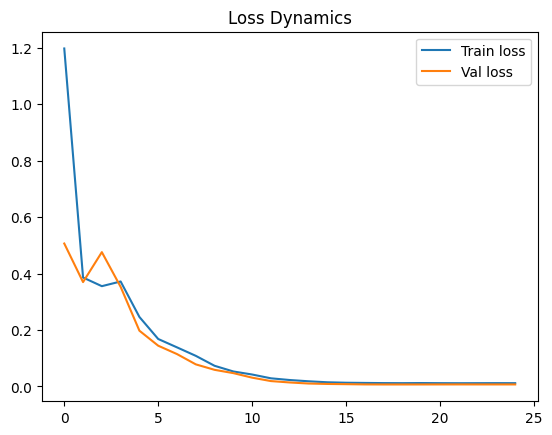

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label="Train loss")
plt.plot(val_hist, label="Val loss")
plt.title("Loss Dynamics")
plt.legend()
plt.show()

1.2 Расширение логистической регрессии (15 баллов)

In [27]:
# Модифицируйте существующую логистическую регрессию:
# - Добавьте поддержку многоклассовой классификации
# - Реализуйте метрики: precision, recall, F1-score, ROC-AUC
# - Добавьте визуализацию confusion matrix

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

class MultiLogisticRegression(nn.Module):
    """Логистическая регрессия для многоклассовой классификации"""
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.fc = nn.Linear(input_dim, n_classes)
    def forward(self, x):
        return self.fc(x)

def metrics_multiclass(y_true, y_pred_logits):
    """
    Метрики precision, recall, f1, roc_auc
    """
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred_logits.argmax(dim=1).cpu().numpy()
    result = {
        'precision': precision_score(y_true_np, y_pred_np, average='macro', zero_division=0),
        'recall': recall_score(y_true_np, y_pred_np, average='macro', zero_division=0),
        'f1': f1_score(y_true_np, y_pred_np, average='macro', zero_division=0),
    }
    try:
        y_score = torch.softmax(y_pred_logits, dim=1).cpu().numpy()
        if y_score.shape[1] == 2:
            result['roc_auc'] = roc_auc_score(y_true_np, y_score[:, 1])
        else:
            y_true_oh = np.eye(y_pred_logits.shape[1])[y_true_np]
            result['roc_auc'] = roc_auc_score(y_true_oh, y_score, multi_class='ovr')
    except Exception:
        result['roc_auc'] = np.nan
    return result


def plot_confusion(y_true, y_pred, class_names=None):
    """Отрисовывает confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(class_names)) if class_names else np.arange(np.max(y_true)+1)
    plt.xticks(tick_marks, class_names if class_names else tick_marks)
    plt.yticks(tick_marks, class_names if class_names else tick_marks)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    for i in range(len(tick_marks)):
        for j in range(len(tick_marks)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()


Epoch 5: loss=57.6296, precision=0.153, recall=0.496, f1=0.234, roc_auc=0.732
Epoch 10: loss=20.7062, precision=0.148, recall=0.473, f1=0.226, roc_auc=0.756
Epoch 15: loss=23.4464, precision=0.341, recall=0.478, f1=0.243, roc_auc=0.807
Epoch 20: loss=8.5227, precision=0.657, recall=0.512, f1=0.262, roc_auc=0.902
Epoch 25: loss=7.1385, precision=0.839, recall=0.779, f1=0.799, roc_auc=0.828
Epoch 30: loss=7.0899, precision=0.689, recall=0.661, f1=0.535, roc_auc=0.933
Epoch 35: loss=4.6026, precision=0.785, recall=0.825, f1=0.794, roc_auc=0.930
Epoch 40: loss=2.9567, precision=0.804, recall=0.846, f1=0.814, roc_auc=0.941
Epoch 45: loss=2.5049, precision=0.768, recall=0.813, f1=0.744, roc_auc=0.956
Epoch 50: loss=2.2546, precision=0.852, recall=0.880, f1=0.863, roc_auc=0.954
Validation scores: {'precision': 0.8521189591078067, 'recall': 0.8797914995990377, 'f1': 0.8629849770134841, 'roc_auc': np.float64(0.9538225073509756)}


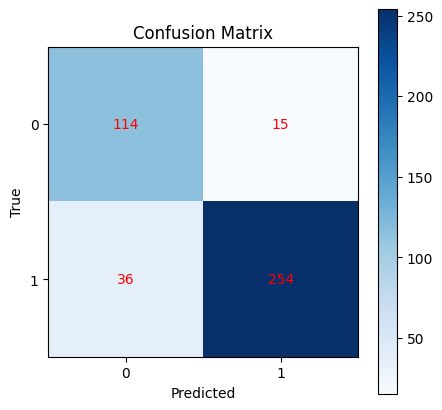

In [29]:
# Модель логистической регресси с breast_cancer

Xc, yc = make_classification_data(n=200, source="breast_cancer")
X_train, X_val = Xc[:150], Xc[150:]
y_train, y_val = yc[:150], yc[150:]
epochs = 50

model = MultiLogisticRegression(Xc.shape[1], 2)
opt = optim.Adam(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()
for epoch in range(epochs):
    model.train()
    out = model(X_train)
    loss = criterion(out, y_train.squeeze().long())
    opt.zero_grad()
    loss.backward()
    opt.step()

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        scores = metrics_multiclass(y_val.squeeze(), val_logits)
    if (epoch+1)%5 == 0 or epoch == epochs-1:
        print(f"Epoch {epoch+1}: loss={loss.item():.4f}, precision={scores['precision']:.3f}, recall={scores['recall']:.3f}, f1={scores['f1']:.3f}, roc_auc={scores['roc_auc']:.3f}")


model.eval()
with torch.no_grad():
    val_logits = model(X_val)
    val_labels = val_logits.argmax(dim=1)
    scores = metrics_multiclass(y_val.squeeze(), val_logits)
    print("Validation scores:", scores)
    plot_confusion(y_val.squeeze().numpy(), val_labels.numpy(), ["0", "1"])


# Задание 2: Работа с датасетами (30 баллов)

2.1 Кастомный Dataset класс (15 баллов)

In [30]:
# Создайте кастомный класс датасета для работы с CSV файлами:
# - Загрузка данных из файла
# - Предобработка (нормализация, кодирование категорий)
# - Поддержка различных форматов данных (категориальные, числовые, бинарные и т.д.)

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class CustomCSVDataset(Dataset):
    """
    Кастомный датасет для работы с CSV
    """
    def __init__(self, csv_path, target_col, categorical=None, binary=None):
        self.data = pd.read_csv(csv_path)
        self.target = torch.tensor(self.data[target_col].values, dtype=torch.float32)
        features = self.data.drop(columns=[target_col])
        cat = categorical or []
        bin_ = binary or []
        num = [c for c in features.columns if c not in cat+bin_]
        tensors = []
        if num:
            scaler = StandardScaler()
            tensors.append(torch.tensor(scaler.fit_transform(features[num]), dtype=torch.float32))
        if bin_:
            tensors.append(torch.tensor(features[bin_].astype(float).values, dtype=torch.float32))
        if cat:
            enc = OneHotEncoder(sparse=False)
            tensors.append(torch.tensor(enc.fit_transform(features[cat]), dtype=torch.float32))
        self.X = torch.cat(tensors, dim=1)
    def __getitem__(self, idx):
        return self.X[idx], self.target[idx]
    def __len__(self):
        return len(self.target)


2.2 Эксперименты с различными датасетами (15 баллов)

In [32]:
# Найдите csv датасеты для регрессии и бинарной классификации и, применяя наработки из предыдущей части задания, обучите линейную и логистическую регрессию

In [33]:
from sklearn.datasets import load_diabetes, load_breast_cancer

# Diabetes для регрессии
diab = load_diabetes()
pd.DataFrame(np.c_[diab.data, diab.target],
             columns=list(diab.feature_names)+["target"]).to_csv("diabetes.csv", index=False)

# Breast_cancer для классификации
bc = load_breast_cancer()
pd.DataFrame(np.c_[bc.data, bc.target],
             columns=list(bc.feature_names)+["target"]).to_csv("breast_cancer.csv", index=False)

In [34]:
# Пример обучения регрессии по diabetes.csv
reg_ds = CustomCSVDataset("diabetes.csv", "target")
loader = DataLoader(reg_ds, batch_size=32, shuffle=True)
model = nn.Linear(reg_ds.X.shape[1], 1)
optim_ = optim.SGD(model.parameters(), lr=0.01)
crit = nn.MSELoss()
for epoch in range(100):
    for Xb, yb in loader:
        optim_.zero_grad()
        loss = crit(model(Xb), yb.unsqueeze(1))
        loss.backward()
        optim_.step()
    if (epoch+1)%5 == 0 or epoch == epochs-1:
      print(f"[Diabetes] Epoch {epoch+1}: loss={loss.item():.4f}")

[Diabetes] Epoch 5: loss=2929.5674
[Diabetes] Epoch 10: loss=2222.2363
[Diabetes] Epoch 15: loss=2801.7383
[Diabetes] Epoch 20: loss=3047.9136
[Diabetes] Epoch 25: loss=2840.0674
[Diabetes] Epoch 30: loss=2917.7896
[Diabetes] Epoch 35: loss=3196.3044
[Diabetes] Epoch 40: loss=2833.6084
[Diabetes] Epoch 45: loss=3305.7739
[Diabetes] Epoch 50: loss=2333.9800
[Diabetes] Epoch 55: loss=2732.4895
[Diabetes] Epoch 60: loss=2322.8103
[Diabetes] Epoch 65: loss=2071.0103
[Diabetes] Epoch 70: loss=3021.8682
[Diabetes] Epoch 75: loss=3951.5610
[Diabetes] Epoch 80: loss=4565.5288
[Diabetes] Epoch 85: loss=2536.9995
[Diabetes] Epoch 90: loss=2503.9773
[Diabetes] Epoch 95: loss=3174.7212
[Diabetes] Epoch 100: loss=2614.7505


In [35]:
# Пример обучения логистической регрессии на breast_cancer.csv
clf_ds = CustomCSVDataset("breast_cancer.csv", "target")
loader = DataLoader(clf_ds, batch_size=32, shuffle=True)
model = nn.Linear(clf_ds.X.shape[1], 1)
optim_ = optim.Adam(model.parameters(), lr=0.01)
crit = nn.BCEWithLogitsLoss()
for epoch in range(100):
    for Xb, yb in loader:
        optim_.zero_grad()
        logits = model(Xb).squeeze(1)
        loss = crit(logits, yb)
        loss.backward()
        optim_.step()
    if (epoch+1)%5 == 0 or epoch == epochs-1:
      print(f"[Cancer] Epoch {epoch+1}: loss={loss.item():.4f}")


[Cancer] Epoch 5: loss=0.0731
[Cancer] Epoch 10: loss=0.0255
[Cancer] Epoch 15: loss=0.1020
[Cancer] Epoch 20: loss=0.0640
[Cancer] Epoch 25: loss=0.0551
[Cancer] Epoch 30: loss=0.0551
[Cancer] Epoch 35: loss=0.0422
[Cancer] Epoch 40: loss=0.2491
[Cancer] Epoch 45: loss=0.0682
[Cancer] Epoch 50: loss=0.0846
[Cancer] Epoch 55: loss=0.0304
[Cancer] Epoch 60: loss=0.0141
[Cancer] Epoch 65: loss=0.0507
[Cancer] Epoch 70: loss=0.0283
[Cancer] Epoch 75: loss=0.0126
[Cancer] Epoch 80: loss=0.1217
[Cancer] Epoch 85: loss=0.0126
[Cancer] Epoch 90: loss=0.0262
[Cancer] Epoch 95: loss=0.0654
[Cancer] Epoch 100: loss=0.0331


# Задание 3: Эксперименты и анализ (20 баллов)

3.1 Исследование гиперпараметров (10 баллов)

In [36]:
# Проведите эксперименты с различными:
# - Скоростями обучения (learning rate)
# - Размерами батчей
# - Оптимизаторами (SGD, Adam, RMSprop)
# Визуализируйте результаты в виде графиков или таблиц

In [37]:
from sklearn.model_selection import train_test_split

dataset = CustomCSVDataset("breast_cancer.csv", target_col="target")
X_all = dataset.X
y_all = dataset.target

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

In [42]:
from torch.utils.data import TensorDataset, DataLoader

def train_multiclass(
    model_class, input_dim, n_classes, X_train, y_train, X_val, y_val,
    optimizer_class, lr, batch_size, epochs=50, device='cpu', verbose=False
):
    model = model_class(input_dim, n_classes).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).long()
            out = model(xb)
            loss = criterion(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # Оценка на val
    model.eval()
    with torch.no_grad():
        val_logits = []
        val_targets = []
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).long()
            out = model(xb)
            val_logits.append(out.cpu())
            val_targets.append(yb.cpu())
        val_logits = torch.cat(val_logits)
        val_targets = torch.cat(val_targets)
        metrics = metrics_multiclass(val_targets, val_logits)
        if verbose:
            print(metrics)
    return metrics, model, val_logits, val_targets

# Перебор гиперпараметро
device = 'cuda' if torch.cuda.is_available() else 'cpu'
experiments = [
    {"lr": 0.1, "batch_size": 32, "optimizer": optim.SGD},
    {"lr": 0.01, "batch_size": 64, "optimizer": optim.Adam},
    {"lr": 0.001, "batch_size": 16, "optimizer": optim.RMSprop},
    {"lr": 0.05, "batch_size": 32, "optimizer": optim.Adam},
]
all_results = []
for exp in experiments:
    metrics, model, val_logits, val_targets = train_multiclass(
        MultiLogisticRegression, X_train.shape[1], 2, X_train, y_train, X_val, y_val,
        exp["optimizer"], exp["lr"], exp["batch_size"], epochs=50, device=device
    )
    result = {**exp, **metrics}
    all_results.append(result)
df_results = pd.DataFrame(all_results)
display(df_results)

,lr,batch_size,optimizer,precision,recall,f1,roc_auc
0,0.100,32,<class 'torch.optim.sgd.SGD'>,0.958766,0.967262,0.962660,0.996032
1,0.010,64,<class 'torch.optim.adam.Adam'>,0.981151,0.981151,0.981151,0.995370
2,0.001,16,<class 'torch.optim.rmsprop.RMSprop'>,0.969702,0.974206,0.971863,0.995701
3,0.050,32,<class 'torch.optim.adam.Adam'>,0.948309,0.960317,0.953534,0.994048


3.2 Feature Engineering (10 баллов)

In [ ]:
# Создайте новые признаки для улучшения модели:
# - Полиномиальные признаки
# - Взаимодействия между признаками
# - Статистические признаки (среднее, дисперсия)
# Сравните качество с базовой моделью

{'precision': 0.9115942028985508, 'recall': 0.9226190476190477, 'f1': 0.9163609684519443, 'roc_auc': np.float64(0.9818121693121693)}
Base F1: 0.9811507936507937 | FE F1: 0.9163609684519443
Feature engineering не дал прироста.


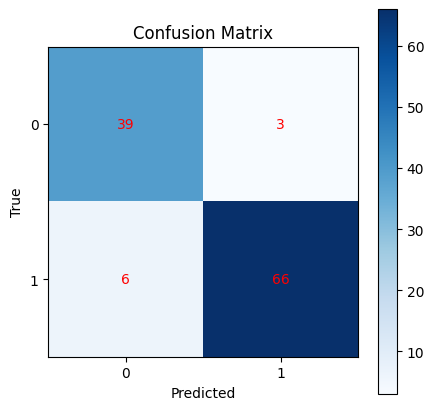

In [49]:
from sklearn.preprocessing import PolynomialFeatures

def featurize(X):
    X_np = X.cpu().numpy()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_np)
    mean = X_np.mean(axis=1, keepdims=True)
    std = X_np.std(axis=1, keepdims=True)
    var = X_np.var(axis=1, keepdims=True)
    return torch.tensor(np.concatenate([X_poly, mean, std, var], axis=1), dtype=torch.float32)

X_train_fe = featurize(X_train)
X_val_fe = featurize(X_val)

# \лучшие гиперпараметры из экспериментов
best = df_results.sort_values("f1", ascending=False).iloc[0]
metrics_fe, model_fe, logits_fe, targets_fe = train_multiclass(
    MultiLogisticRegression, X_train_fe.shape[1], 2, X_train_fe, y_train, X_val_fe, y_val,
    best["optimizer"], best["lr"], int(best["batch_size"]), epochs=100, device=device, verbose=True
)
print("Base F1:", best["f1"], "| FE F1:", metrics_fe["f1"])
if metrics_fe["f1"] > best["f1"]:
    print("Feature engineering модель улучшена")
else:
    print("Feature engineering не дал прироста.")

# Confusion matrix для FE модели
plot_confusion(targets_fe.numpy(), logits_fe.argmax(dim=1).numpy(), class_names=["0", "1"])
